In [48]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
from utils import calculate_iou


def get_ss_proposals(image_name):
    # Extract predicted boxes
    with open(os.path.join('Potholes', 'annotated-images', image_name + '_ss.json')) as f:
        pred_boxes = json.load(f)
    
    # Extract bounding box coordinates
    pred_boxes = [pred_box['bbox'] for pred_box in pred_boxes]
    
    return pred_boxes
    

def bounding_box_recall_and_mabo(n_proposals_range, threshold=0.7, proposal_getter = get_ss_proposals):
    #n_proposals_range: list of integers, x-ticks for plot
    #threshold: float in [0,1], IOU threshold for a correct detection
    #proposal_getter: function that takes an image name such as 'img-1' and returns a list of bounding boxes in [xmin, ymin, xmax, ymax] format
    
    # Use only training data
    with open(os.path.join('Potholes', 'splits.json')) as f:
        splits = json.load(f)
    
    xml_names = splits['train']
    
    # Strip .xml
    image_names = [xml_name[:-4] for xml_name in xml_names]
    
    recalls = {k: [] for k in n_proposals_range}
    mabos = {k: [] for k in n_proposals_range}
    
    # Loop through images
    for image_name in image_names:
        # Extract ground truth    
        tree = ET.parse(os.path.join('Potholes', 'annotated-images', image_name + '.xml'))
        root = tree.getroot()
        GT_boxes = [
            [int(box.find("bndbox/xmin").text), 
             int(box.find("bndbox/ymin").text), 
             int(box.find("bndbox/xmax").text), 
             int(box.find("bndbox/ymax").text)]
            for box in root.iter('object')
        ]
        
        pred_boxes = proposal_getter(image_name)
        
        # Precompute IOUs for all GT and predicted boxes
        iou_matrix = np.array([[calculate_iou(gt_box, pred_box) for pred_box in pred_boxes] for gt_box in GT_boxes])
        
        for n_proposals in n_proposals_range:
            # Extract only the first included_proposals (may be greater than the number of proposals)
            limited_pred_boxes = pred_boxes[:n_proposals]
            
            # Calculate max IOUs using the precomputed IOU matrix
            max_ious = np.max(iou_matrix[:, :n_proposals], axis=1)
            
            # Threshold
            recalls[n_proposals].append(np.mean(max_ious > threshold))
            
            # Calculate MABO
            mabos[n_proposals].append(np.mean(max_ious))
    
    # Calculate mean recall and MABO for each n_proposals
    mean_recalls = {k: np.mean(v) for k, v in recalls.items()}
    mean_mabos = {k: np.mean(v) for k, v in mabos.items()}
    
    
    return mean_recalls, mean_mabos

In [49]:
# Example usage
n_proposals_range = np.arange(10, 3000, 30)
recall, mabo = bounding_box_recall_and_mabo(n_proposals_range)

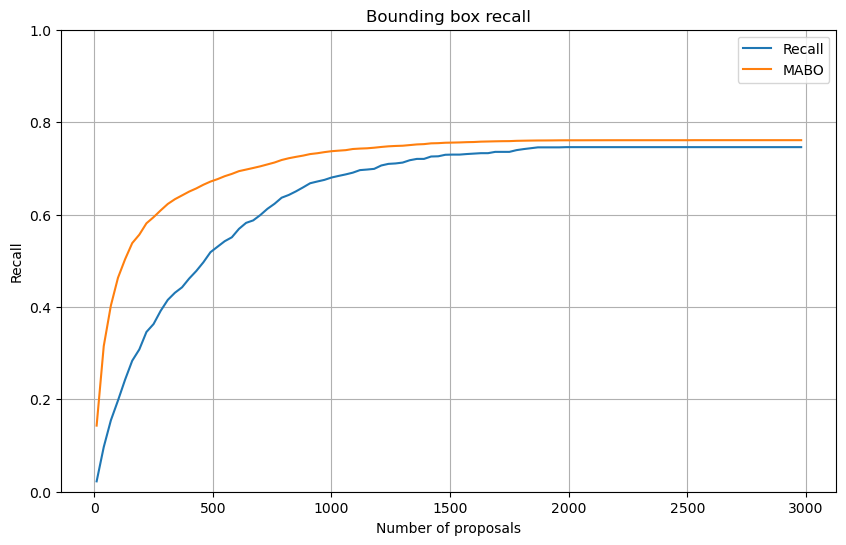

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(n_proposals_range, [recalls[k] for k in n_proposals_range], label='Recall')
plt.plot(n_proposals_range, [mabo[k] for k in n_proposals_range], label='MABO')

plt.grid(True)
plt.xlabel('Number of proposals')
plt.ylabel('Recall')
plt.title('Bounding box recall')
plt.ylim(0, 1)

plt.legend()
plt.show()